In [7]:
#inlcudes 
import numpy as np
import matplotlib.pyplot as plt
from cadet import Cadet


In [8]:
def create_base_system(model, ncomp, init_c):
    """Create a basic CSTR system with inlet, CSTR and outlet"""
    # CSTR
    model.root.input.model.nunits = 3
    
    # Inlet
    model.root.input.model.unit_000.unit_type = 'INLET'
    model.root.input.model.unit_000.ncomp = ncomp
    model.root.input.model.unit_000.inlet_type = 'PIECEWISE_CUBIC_POLY'
    
    # CSTR
    model.root.input.model.unit_001.unit_type = 'CSTR'
    model.root.input.model.unit_001.ncomp = ncomp
    model.root.input.model.unit_001.init_liquid_volume = 1.0
    model.root.input.model.unit_001.init_c = init_c
    model.root.input.model.unit_001.const_solid_volume = 1.0
    model.root.input.model.unit_001.use_analytic_jacobian = 1
    
    # Outlet
    model.root.input.model.unit_002.unit_type = 'OUTLET'
    model.root.input.model.unit_002.ncomp = ncomp

    # Return data
    model.root.input['return'].split_components_data = 0
    model.root.input['return'].split_ports_data = 0
    model.root.input['return'].unit_000.write_solution_bulk = 1
    model.root.input['return'].unit_000.write_solution_inlet = 1
    model.root.input['return'].unit_000.write_solution_outlet = 1

    model.root.input['return'].unit_001 = model.root.input['return'].unit_000
    model.root.input['return'].unit_002 = model.root.input['return'].unit_000

def setup_solver(model, sim_time=300.0):
    """Configure solver settings"""
    model.root.input.solver.user_solution_times = np.linspace(0, sim_time, 1000)
    model.root.input.solver.sections.nsec = 1
    model.root.input.solver.sections.section_times = [0.0, sim_time]
    model.root.input.solver.sections.section_continuity = []
    
    model.root.input.model.solver.gs_type = 1
    model.root.input.model.solver.max_krylov = 0
    model.root.input.model.solver.max_restarts = 10
    model.root.input.model.solver.schur_safety = 1e-8
    
    model.root.input.solver.time_integrator.abstol = 1e-6
    model.root.input.solver.time_integrator.algtol = 1e-10
    model.root.input.solver.time_integrator.reltol = 1e-6
    model.root.input.solver.time_integrator.init_step_size = 1e-6
    model.root.input.solver.time_integrator.max_steps = 1000000
    model.root.input.solver.consistent_init_mode = 1

def setup_connections( model, ncomp):
    """Connect the units together"""
    # Connections
    model.root.input.model.connections.nswitches = 1
    model.root.input.model.connections.switch_000.section = 0
    model.root.input.model.connections.switch_000.connections = [
        0, 1, -1, -1, 0.0,  # [unit_000, unit_001, all components, all components, Q/ m^3*s^-1]
        1, 2, -1, -1, 0.0   # [unit_001, unit_002, all components, all components, Q/ m^3*s^-1]
    ]

    # Inlet coefficients - no inflow
    model.root.input.model.unit_000.sec_000.const_coeff = [0.0] * ncomp
    model.root.input.model.unit_000.sec_000.lin_coeff = [0.0] * ncomp
    model.root.input.model.unit_000.sec_000.quad_coeff = [0.0] * ncomp
    model.root.input.model.unit_000.sec_000.cube_coeff = [0.0] * ncomp

In [9]:
# Cadet Setup

install_path = r'C:\Users\berger\CADET\out\install\DEBUG\bin\cadet-cli.exe'

model_do = Cadet(r'C:\Users\berger\CADET-Core\out\install\DEBUG\bin\cadet-cli.exe')

nComp = 5 
sim_time = 500.0
# c_PD0, c_NAD0, c_Lactol0, c_NADH0, c_Lacton0
init_c = [100, 8, 1e-6, 1e-6, 1e-6] 

create_base_system(model=model_do, ncomp=nComp, init_c= init_c)
setup_solver(model_do, sim_time=sim_time)
setup_connections(model_do, nComp)


c:\Users\berger\AppData\Local\miniforge3\envs\CadetDev\Lib\site-packages\cadet\cadet.py:59: UserWarning: The specified install_path is not the root of the CADET installation. It has been inferred from the file path.
  warnings.warn(


In [10]:
# Parameter für Michaelis Menten system 

vmax1_per_mg, vmax1_std_per_mg = 0.07, 0.002
Km_PD, Km_PD_std = 84, 16
Km_NAD1, Km_NAD1_std = 2.2, 0.2

vmax2_per_mg, vmax2_std_per_mg = 2.26, 1.63
Km_Lactol, Km_Lactol_std = 111, 16
Km_NADH, Km_NADH_std = 2.9, 2.42
Ki_PD, Ki_PD_std = 90, 19
Ki_NAD, Ki_NAD_std = 1.12, 0.4

vmax3_per_mg, vmax3_std_per_mg = 2.3, 0.1
Km_Lactol2, Km_Lactol2_std = 62, 9
Ki_Lacton, Ki_Lacton_std = 108, 48
Km_NAD2, Km_NAD2_std = 2.8, 0.3


In [11]:
# DO- Simulation 

from scipy.integrate import solve_ivp

t_span = (0, 500)
t_eval = np.linspace(0, 500, 1000)

def reaction_rates(y):
        c_PD, c_NAD, c_Lactol, c_NADH, c_Lacton = [max(1e-6, val) for val in y]  # Verhindert zu kleine Werte
        
        r1 = (vmax1_per_mg * c_PD * c_NAD) / ((c_PD + Km_PD) * (c_NAD + Km_NAD1))
        r2 = (vmax2_per_mg * c_Lactol * c_NADH) / ((c_Lactol + Km_Lactol * (1 + c_PD / Ki_PD)) * (c_NADH + Km_NADH * (1 + c_NAD / Ki_NAD)))
        r3 = (vmax3_per_mg * c_Lactol * c_NAD) / ((c_Lactol + Km_Lactol2 * (1 + c_Lacton / Ki_Lacton)) * (c_NAD + Km_NAD2))
        
        return [-r1 + r2, 
                -r1 + r2 - r3, 
                r1 - r2 - r3, 
                r1 - r2 + r3, 
                r3], r1, r2, r3
    
def ode_system(t, y):
        rates, r1, r2, r3 = reaction_rates(y)
        return rates
    
sol = solve_ivp(ode_system, t_span, init_c, t_eval=t_eval, method='RK45')


In [12]:


model_do.root.input.model.unit_001.reaction_model = 'MICHAELIS_MENTEN'

# Km values - single reaction, A is the substrate
model_do.root.input.model.unit_001.reaction_bulk.mm_kmm = [
    [Km_PD, Km_NAD1, 0.0, 0.0, 0.0],
    [0.0, 0.0, Km_Lactol, Km_NADH, 0.0],
    [0.0, Km_NAD2, Km_Lactol2, 0.0, 0.0]
]



# Competitive inhibition constants - 3D array [reaction][substrate][inhibitor]
model_do.root.input.model.unit_001.reaction_bulk.mm_ki_c = [
    [
        [0.0, 0.0, 0.0, 0.0, 0.0],   # PD
        [0.0, 0.0, 0.0, 0.0, 0.0],   # NAD
        [0.0, 0.0, 0.0, 0.0, 0.0],   # LTOL
        [0.0, 0.0, 0.0, 0.0, 0.0],   # NADH
        [0.0, 0.0, 0.0, 0.0, 0.0]    # LTOL
    ],
       [
        [0.0, 0.0, 0.0, 0.0, 0.0],   # PD
        [0.0, 0.0, 0.0, 0.0, 0.0],   # NAD
        [Ki_PD, 0.0, 0.0, 0.0, 0.0],  # LTOL
        [0.0, Ki_NAD, 0.0, 0.0, 0.0], # NADH
        [0.0, 0.0, 0.0, 0.0, 0.0]    # LTOL
    ],
       [
        [0.0, 0.0, 0.0, 0.0, 0.0],   # PD
        [0.0, 0.0, 0.0, 0.0, 0.0],   # NAD
        [0.0, 0.0, 0.0, 0.0, Ki_Lacton],   # LTOL
        [0.0, 0.0, 0.0, 0.0, 0.0],   # NADH
        [0.0, 0.0, 0.0, 0.0, 0.0]    # LTOL
    ]
]

# Uncompetitive inhibition constants (not used in this test)
model_do.root.input.model.unit_001.reaction_bulk.mm_ki_uc = [
        [
        [0.0, 0.0, 0.0, 0.0, 0.0],   # PD
        [0.0, 0.0, 0.0, 0.0, 0.0],   # NAD
        [0.0, 0.0, 0.0, 0.0, 0.0],   # LTOL
        [0.0, 0.0, 0.0, 0.0, 0.0],   # NADH
        [0.0, 0.0, 0.0, 0.0, 0.0]    # LTON
    ],
       [
        [0.0, 0.0, 0.0, 0.0, 0.0],   # PD
        [0.0, 0.0, 0.0, 0.0, 0.0],   # NAD
        [0.0, 0.0, 0.0, 0.0, 0.0],   # LTOL
        [0.0, 0.0, 0.0, 0.0, 0.0],   # NADH
        [0.0, 0.0, 0.0, 0.0, 0.0]    # LTON
    ],
       [
        [0.0, 0.0, 0.0, 0.0, 0.0],   # PD
        [0.0, 0.0, 0.0, 0.0, 0.0],   # NAD
        [0.0, 0.0, 0.0, 0.0, 0.0],   # LTOL
        [0.0, 0.0, 0.0, 0.0, 0.0],   # NADH
        [0.0, 0.0, 0.0, 0.0, 0.0]    # LTON
    ]
]



# Vmax and stoichiometry
model_do.root.input.model.unit_001.reaction_bulk.mm_vmax = [vmax1_per_mg, vmax2_per_mg, vmax3_per_mg]
model_do.root.input.model.unit_001.reaction_bulk.mm_stoichiometry_bulk = [
        [-1, 1, 0],     # PD
        [-1, 1,-1],     # NAD
        [ 1,-1,-1],     # LTOL
        [ 1,-1, 1],     # NADH
        [ 0, 0, 1]      # LTON
]

model_do.filename = "do_enzyme_system.h5"
model_do.save()
data_mm = model_do.run()
model_do.load()

# Extract CADET simulation results
c_cadet = model_do.root.output.solution.unit_001.solution_outlet
times_cadet = model_do.root.output.solution.solution_times

print(data_mm)

c:\Users\berger\AppData\Local\miniforge3\envs\CadetDev\Lib\site-packages\cadet\cadet.py:569: FutureWarning: Cadet.run() will be removed in a future release. 
Please use Cadet.run_simulation()
  warnings.warn(


ReturnInformation(return_code=0, error_message='', log='[Debug: Simulator::373] Resetting AD directions from 80 to default 80\r\n[Debug: pushScope::140] SCOPE solver\r\n[Debug: pushScope::140] SCOPE time_integrator\r\n[Debug: exists::120] EXISTS USE_MODIFIED_NEWTON = no\r\n[Debug: isArray::127] ISARRAY ABSTOL = no\r\n[Debug: getDouble::46] GET scalar [double] ABSTOL = 9.9999999999999995e-07\r\n[Debug: getDouble::46] GET scalar [double] RELTOL = 9.9999999999999995e-07\r\n[Debug: getDouble::46] GET scalar [double] ALGTOL = 1.0000000000000000e-10\r\n[Debug: getInt::53] GET scalar [int] MAX_STEPS = 1000000\r\n[Debug: exists::120] EXISTS MAX_STEP_SIZE = no\r\n[Debug: isArray::127] ISARRAY INIT_STEP_SIZE = no\r\n[Debug: getDouble::46] GET scalar [double] INIT_STEP_SIZE = 9.9999999999999995e-07\r\n[Debug: exists::120] EXISTS RELTOL_SENS = no\r\n[Debug: exists::120] EXISTS ERRORTEST_SENS = no\r\n[Debug: exists::120] EXISTS MAX_NEWTON_ITER = no\r\n[Debug: exists::120] EXISTS MAX_ERRTEST_FAIL = 

c:\Users\berger\AppData\Local\miniforge3\envs\CadetDev\Lib\site-packages\cadet\cadet.py:594: FutureWarning: Cadet.load() will be removed in a future release. 
Please use Cadet.load_from_file() to load results from a file or use Cadet.run_simulation() to run a simulation and directly load the simulation results.
  warnings.warn(


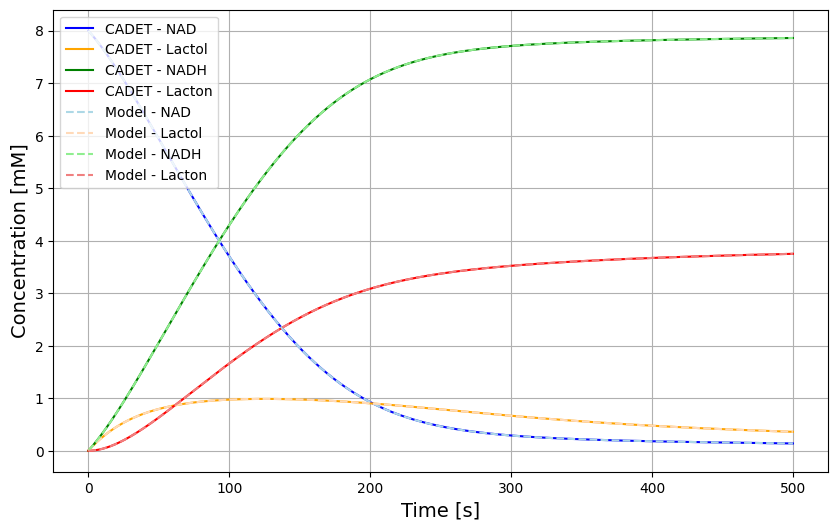

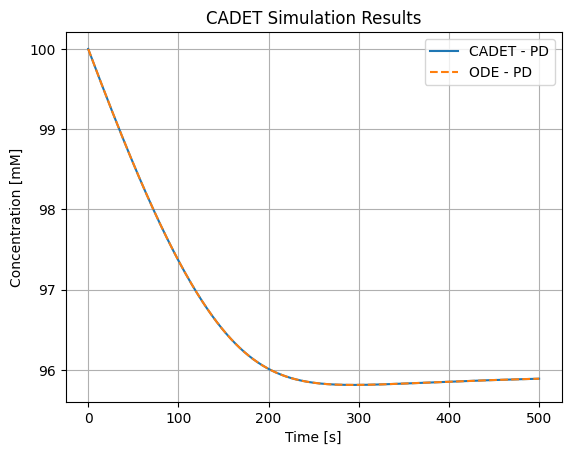

In [ ]:
# Plotting
# Plot simulation results

# Compare ODE simulation results with CADET results
plt.figure(figsize=(10, 6))
plt.plot(times_cadet, c_cadet[:, 1], label='CADET - NAD',color='blue')
plt.plot(times_cadet, c_cadet[:, 2], label='CADET - Lactol',color='orange')
plt.plot(times_cadet, c_cadet[:, 3], label='CADET - NADH ', color='green')
plt.plot(times_cadet, c_cadet[:, 4], label='CADET - Lacton', color='red')
plt.plot(sol.t, sol.y[1], label='Model - NAD', linestyle='--', color='lightblue')
plt.plot(sol.t, sol.y[2], label='Model - Lactol', linestyle='--', color='peachpuff')
plt.plot(sol.t, sol.y[3], label='Model - NADH', linestyle='--', color='lightgreen')
plt.plot(sol.t, sol.y[4], label='Model - Lacton', linestyle='--',color='lightcoral')
plt.xlabel('Time [s]', fontsize=14)
plt.ylabel('Concentration [mM]', fontsize=14)
plt.legend(fontsize=14)
plt.grid()
plt.show()

plt.plot(times_cadet, c_cadet[:, 0], label='CADET - PD')
plt.plot(sol.t, sol.y[0], label='ODE - PD', linestyle='--')
plt.xlabel('Time [s]')
plt.ylabel('Concentration [mM]')
plt.title('CADET Simulation Results')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Hellblau Farboptionen für Plots:
# 'lightblue' - Standard hellblau
# 'skyblue' - Himmelblau 
# 'lightsteelblue' - Helles Stahlblau
# 'powderblue' - Puderblau
# 'lightcyan' - Helles Cyan
# '#ADD8E6' - Hex-Code für hellblau
# '#87CEEB' - Hex-Code für Himmelblau

# Beispiel mit hellblau:
plt.figure(figsize=(12, 8))

# Subplot 1: Alle Komponenten außer PD
plt.subplot(2, 1, 1)
plt.plot(times_cadet, c_cadet[:, 1], label='CADET - NAD', color='lightblue', linewidth=2)
plt.plot(times_cadet, c_cadet[:, 2], label='CADET - Lactol', color='orange', linewidth=2)
plt.plot(times_cadet, c_cadet[:, 3], label='CADET - NADH', color='green', linewidth=2)
plt.plot(times_cadet, c_cadet[:, 4], label='CADET - Lacton', color='red', linewidth=2)
plt.plot(sol.t, sol.y[1], label='ODE - NAD', linestyle='--', color='skyblue', linewidth=2)
plt.plot(sol.t, sol.y[2], label='ODE - Lactol', linestyle='--', color='orange', alpha=0.7, linewidth=2)
plt.plot(sol.t, sol.y[3], label='ODE - NADH', linestyle='--', color='green', alpha=0.7, linewidth=2)
plt.plot(sol.t, sol.y[4], label='ODE - Lacton', linestyle='--', color='red', alpha=0.7, linewidth=2)
plt.xlabel('Time [s]', fontsize=12)
plt.ylabel('Concentration [mM]', fontsize=12)
plt.title('CADET vs ODE Simulation - Cofactors and Products', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)

# Subplot 2: Nur PD (Substrat)
plt.subplot(2, 1, 2)
plt.plot(times_cadet, c_cadet[:, 0], label='CADET - PD', color='darkblue', linewidth=2)
plt.plot(sol.t, sol.y[0], label='ODE - PD', linestyle='--', color='lightsteelblue', linewidth=2)
plt.xlabel('Time [s]', fontsize=12)
plt.ylabel('Concentration [mM]', fontsize=12)
plt.title('CADET vs ODE Simulation - Substrate (PD)', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

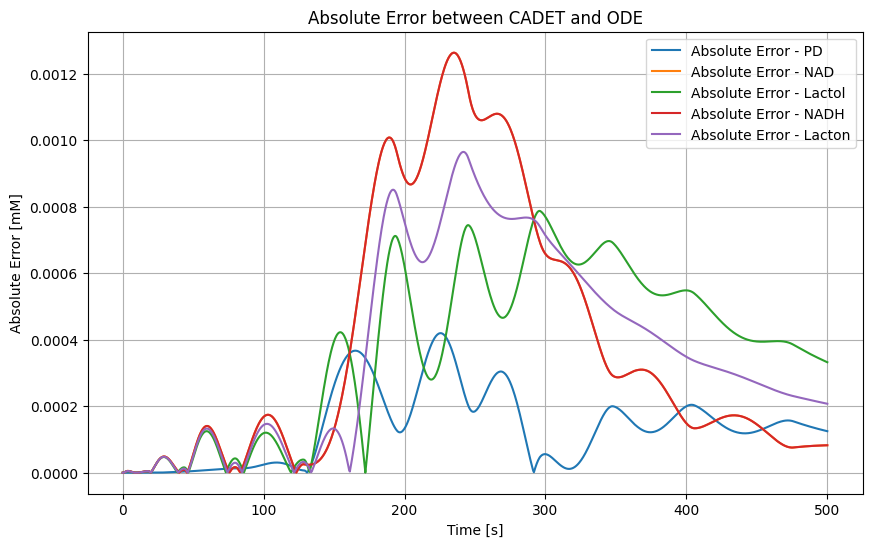

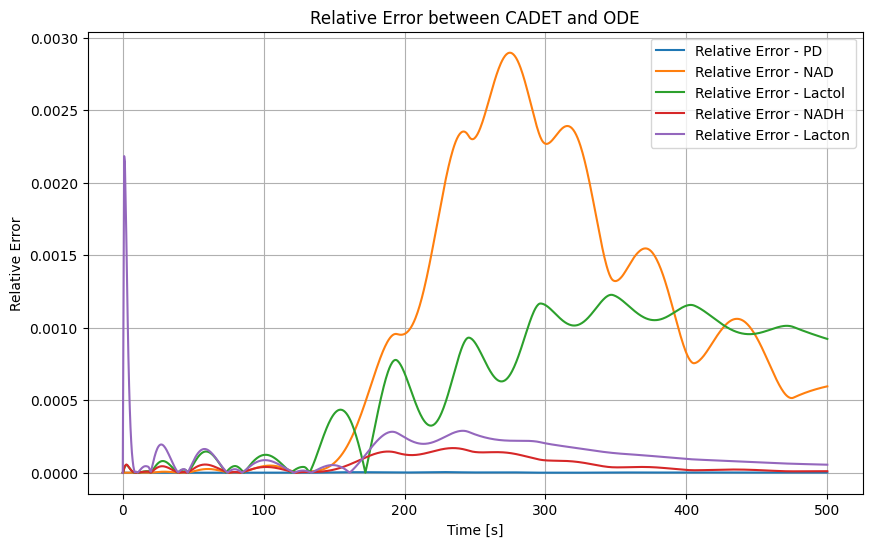

In [ ]:
# Berechnung des absoluten und relativen Fehlers
absolute_error = np.abs(c_cadet - sol.y.T)
relative_error = np.abs((c_cadet - sol.y.T) / sol.y.T)

# Plot des absoluten Fehlers
plt.figure(figsize=(10, 6))
for i, label in enumerate(['PD', 'NAD', 'Lactol', 'NADH', 'Lacton']):
    plt.plot(times_cadet, absolute_error[:, i], label=f'Absolute Error - {label}')
plt.xlabel('Time [s]')
plt.ylabel('Absolute Error [mM]')
plt.title('Absolute Error between CADET and ODE')
plt.legend()
plt.grid()
plt.show()

# Plot des relativen Fehlers
plt.figure(figsize=(10, 6))
for i, label in enumerate(['PD', 'NAD', 'Lactol', 'NADH', 'Lacton']):
    plt.plot(times_cadet, relative_error[:, i], label=f'Relative Error - {label}')
plt.xlabel('Time [s]')
plt.ylabel('Relative Error')
plt.title('Relative Error between CADET and ODE')
plt.legend()
plt.grid()
plt.show()

In [ ]:
def calculate_fisher_information_matrix(simulation_times, parameters, concentrations, noise_level=0.01):
    import numpy as np
    from scipy.optimize import approx_fprime
    
    # Anzahl der Parameter und Messzeitpunkte
    n_params = len(parameters)
    n_timepoints = len(simulation_times)
    n_species = concentrations.shape[1]  # Anzahl der chemischen Spezies
    
    # Initialisierung der Sensitivitätsmatrix
    sensitivity_matrix = np.zeros((n_timepoints * n_species, n_params))
    
    # Epsilon für numerische Ableitung
    epsilon = 1e-6 * np.array(parameters)
    
    # Funktion zur Simulation mit gegebenen Parametern
    def simulation_function(params):
        # Setze Parameter
        vmax1_per_mg, Km_PD, Km_NAD1, vmax2_per_mg, Km_Lactol, Km_NADH, Ki_PD, Ki_NAD, vmax3_per_mg, Km_Lactol2, Ki_Lacton, Km_NAD2 = params
        
        # Führe ODE-Integration mit neuen Parametern durch
        def new_reaction_rates(y):
            c_PD, c_NAD, c_Lactol, c_NADH, c_Lacton = [max(1e-6, val) for val in y]
            
            r1 = (vmax1_per_mg * c_PD * c_NAD) / ((c_PD + Km_PD) * (c_NAD + Km_NAD1))
            r2 = (vmax2_per_mg * c_Lactol * c_NADH) / ((c_Lactol + Km_Lactol * (1 + c_PD / Ki_PD)) * (c_NADH + Km_NADH * (1 + c_NAD / Ki_NAD)))
            r3 = (vmax3_per_mg * c_Lactol * c_NAD) / ((c_Lactol + Km_Lactol2 * (1 + c_Lacton / Ki_Lacton)) * (c_NAD + Km_NAD2))
            
            return [-r1 + r2, 
                    -r1 + r2 - r3, 
                    r1 - r2 - r3, 
                    r1 - r2 + r3, 
                    r3], r1, r2, r3
        
        def new_ode_system(t, y):
            rates, r1, r2, r3 = new_reaction_rates(y)
            return rates
        
        # Führe Simulation durch
        from scipy.integrate import solve_ivp
        init_c = [100, 8, 1e-6, 1e-6, 1e-6]  # Initial conditions
        sol = solve_ivp(new_ode_system, (0, simulation_times[-1]), init_c, t_eval=simulation_times, method='RK45')
        
        # Flatten der Simulationsergebnisse für alle Spezies
        return sol.y.T.flatten()
    
    # Berechne Sensitivitäten für jeden Parameter durch numerische Differentiation
    for i in range(n_params):
        # Einfache zentrale Differenz für die Ableitung
        perturbed_params_plus = parameters.copy()
        perturbed_params_plus[i] += epsilon[i]
        
        perturbed_params_minus = parameters.copy()
        perturbed_params_minus[i] -= epsilon[i]
        
        y_plus = simulation_function(perturbed_params_plus)
        y_minus = simulation_function(perturbed_params_minus)
        
        # Zentrale Differenz: (f(x+h) - f(x-h)) / (2*h)
        sensitivity = (y_plus - y_minus) / (2 * epsilon[i])
        sensitivity_matrix[:, i] = sensitivity
    

    sim_results = simulation_function(parameters)
    sim_results_reshaped = sim_results.reshape(n_timepoints, n_species)
    
    weights = np.zeros_like(sim_results)
    for i in range(n_species):
        species_values = sim_results_reshaped[:, i]
        species_std = noise_level * np.abs(species_values) + 1e-10  # Vermeidet Division durch 0
        weights[i*n_timepoints:(i+1)*n_timepoints] = 1.0 / (species_std**2)
    
    # Gewichtungsmatrix als Diagonalmatrix
    W = np.diag(weights)
    
    # Berechnung der Fisher-Informationsmatrix
    FIM = sensitivity_matrix.T @ W @ sensitivity_matrix
    
    # Berechne Parametervarianz (Diagonalelemente der inversen FIM)
    try:
        FIM_inv = np.linalg.inv(FIM)
        parameter_variances = np.diag(FIM_inv)
    except np.linalg.LinAlgError:
        print("Warnung: FIM ist singulär oder schlecht konditioniert")
        # Verwende Pseudoinverse für näherungsweise Berechnung
        FIM_inv = np.linalg.pinv(FIM)
        parameter_variances = np.diag(FIM_inv)
    
    return FIM, parameter_variances

# Verwendung:
# Extrahiere alle Parameter als Liste
all_parameters = [
    vmax1_per_mg, 2.0, 2.0,  # Replace Km_PD and Km_NAD1 with default values
    vmax2_per_mg, 2.0, 2.0,  # Replace Km_Lactol and Km_NADH with default values
    1.0, 1.0,                # Replace Ki_PD and Ki_NAD with default values
    vmax3_per_mg, 2.0, 1.0,  # Replace Km_Lactol2 and Ki_Lacton with default values
    2.0,                     # Replace Km_NAD2 with a default value
    0.0, 0.0, 0.0            # Add default values for missing parameters
]

# Konzentrationen aus deiner ODE-Lösung oder CADET-Lösung
concentrations = sol.y.T  # Transponierte Lösung vom ODE solver

# Berechne FIM
FIM, parameter_variances = calculate_fisher_information_matrix(
    simulation_times=sol.t,
    parameters=all_parameters,
    concentrations=concentrations,
    noise_level=0.05  # 5% Messrauschen
)

# Zeige Ergebnisse
parameter_names = [
    "vmax1", "Km_PD", "Km_NAD1",
    "vmax2", "Km_Lactol", "Km_NADH", "Ki_PD", "Ki_NAD",
    "vmax3", "Km_Lactol2", "Ki_Lacton", "Km_NAD2"
]

print("Fisher-Informationsmatrix:")
print(FIM)
print("\nParametervarianzen:")
for name, var in zip(parameter_names, parameter_variances):
    print(f"{name}: {var:.6e} (95%-KI: ±{1.96*np.sqrt(var):.6e})")



ValueError: too many values to unpack (expected 12)